In [2]:
import os

import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random

import logging
import time
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras import backend as K

In [3]:
from google.colab import drive
drive.mount('/content/drive')
#file_path = '/content/drive/MyDrive/boilers_drive/normalized_df.csv'
train_csv_path = '/content/drive/MyDrive/boilers_drive/train_df.csv'
val_csv_path = '/content/drive/MyDrive/boilers_drive/val_df.csv'
test_csv_path = '/content/drive/MyDrive/boilers_drive/test_df.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Specify the file path of your CSV file

# Read the CSV file
train_data = pd.read_csv(train_csv_path)
val_data = pd.read_csv(val_csv_path)
test_data = pd.read_csv(test_csv_path)

In [5]:
#print(train_data)
#print(val_data)
#print(test_data)

In [6]:
# load pre-prepared random order of houses

random_order_houses = pd.read_csv('/content/drive/MyDrive/boilers_drive/random_order_houses.csv')

In [7]:
# Different houses in data
houses = random_order_houses['house_id'].unique().tolist()
print("Different houses in data:")
print(houses)
print("Number of different houses:")
print(len(houses))

Different houses in data:
['home9', 'home114', 'home5', 'home89', 'home17', 'home63', 'home2', 'home101', 'home14', 'home95', 'home111', 'home67', 'home77', 'home43', 'home86', 'home90', 'home47', 'home110', 'home93', 'home53', 'home34', 'home51', 'home106', 'home46', 'home79', 'home55', 'home65', 'home13']
Number of different houses:
28


**Preparing the data**

In [8]:
# the categories for prediction
final_category = 'blr_mod_lvl'
#prediction_categories = ['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out']
all_categories = train_data.columns.tolist()
print("All categories in the data:")
print(all_categories)

prediction_categories = all_categories.copy()
prediction_categories.remove('time')
prediction_categories.remove('house_id')

print("Prediction categories:")
print(prediction_categories)
#normalized_categories = ['normalized_blr_mod_lvl', 'normalized_absorption', 'normalized_insulation', 'normalized_t_r_set', 'normalized_t_out']

All categories in the data:
['time', 'house_id', 'blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out', 'blr_t', 'heat', 'flame', 'water', 't_ret', 't_r', 't_set', 'otc_cur', 'otc_maxt', 'bypass', 'year', 'month', 'day', 'day_of_year', 'hour', 'minute']
Prediction categories:
['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out', 'blr_t', 'heat', 'flame', 'water', 't_ret', 't_r', 't_set', 'otc_cur', 'otc_maxt', 'bypass', 'year', 'month', 'day', 'day_of_year', 'hour', 'minute']


In [9]:
# creating sub-lists, each with the data of one day
# the function that gets category data of a house (ordered by date) and separates by day
def separate_into_days(data_list, minutes_per_day=1440):
    # number of days
    num_days = len(data_list) // minutes_per_day
    # the data into a list of sub-lists, each containing one day's data
    separated_data = [
        data_list[i * minutes_per_day:(i + 1) * minutes_per_day]
        for i in range(num_days)
    ]
    return separated_data


# function to "combine" values of categories and separate into sub-lists based on days
def combine_categories(dataset, categories_list):
    # Combine specified categories into lists
    combined_elements = dataset[categories_list].apply(lambda row: row.tolist(), axis=1)
    return combined_elements.tolist()

In [10]:
def prepare_data_2(house_data, input_categories, output_category, minutes_per_day=1440):
    combined_input_data = combine_categories(house_data, input_categories)
    separated_input_data = separate_into_days(combined_input_data, minutes_per_day)
    output = house_data[output_category].values
    separated_output = separate_into_days(output, minutes_per_day)
    # [:, :-1] and [:, 1:] for 2-d arrays
    # [:-1],  and [1:] for 1-d arrays (or lists)
    # all except last day are inputs (for prediction)
    input_data = separated_input_data[:-1]
    # all except first day are the corresponding outputs (from prediction)
    output_data = separated_output[1:]
    return input_data, output_data

In [11]:
# function for getting input and target data
def input_target_split (data, input_categories, selected_houses, output_category='blr_mod_lvl'):
    #filtered_data = data[all_categories].copy()
    filtered_data = data.copy()
    input_chosen_categories = []
    #for cat in input_categories:
    #    input_chosen_categories.append('normalized_'+cat)

    # We have 1440 minutes per day
    minutes_per_day = 1440

    # Initialize lists to store input and target pairs
    input_data_list, target_data_list = [], []

    for house_id in selected_houses:
        house_data = filtered_data[filtered_data['house_id'] == house_id]
        house_data = house_data.sort_values(by='time')
        input_data, target_data = prepare_data_2(house_data, input_categories, output_category)
        input_data_list.append(input_data)
        target_data_list.append(target_data)

    # Combine all houses' data
    input_data = np.concatenate(input_data_list, axis=0)
    target_data = np.concatenate(target_data_list, axis=0)

    return input_data, target_data


In [12]:
def get_split_data(train_data, val_data, input_categories, selected_houses, output_category='blr_mod_lvl'):
    input_train, target_train = input_target_split(train_data, input_categories, selected_houses, output_category)
    input_val, target_val = input_target_split(val_data, input_categories, selected_houses, output_category)
    #input_test, target_test = input_target_split(test_data, input_categories, selected_houses)
    return input_train, target_train, input_val, target_val

In [13]:
batch_size = 64

In [14]:
def get_datasets(input_train, target_train, input_val, target_val, batch_size=batch_size):
    # Reduce the batch size, in case it helps !
    # Convert to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train))
    #train_dataset = train_dataset.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((input_val, target_val))
    val_dataset = val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    #test_dataset = tf.data.Dataset.from_tensor_slices((input_test, target_test))
    #test_dataset = test_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    # !!! we do this for test_data separatelly later

    # The validation_split argument is designed to work with NumPy arrays or TensorFlow tensors,
    # where it can easily split the data based on a fraction.
    # It doesn't directly work with TensorFlow datasets because they handle data differently.
    return train_dataset, val_dataset

In [15]:
def print_shapes(input_train, target_train, input_val, target_val):
    print(input_train.shape)
    print(target_train.shape)
    print(input_val.shape)
    print(target_val.shape)
    #print(input_test.shape)
    #print(target_test.shape)
    num_of_categories = input_train.shape[-1]
    print("Number of categories for prediction: "+str(num_of_categories))
    return num_of_categories

In [16]:
# to calculate the R2 during training and predicting
def r2_score(y_true, y_pred):
    # Flatten the arrays to compute R2 on all predicted values at once
    y_true_flat = tf.reshape(y_true, shape=(-1,))
    y_pred_flat = tf.reshape(y_pred, shape=(-1,))

    # Ensure both tensors are of the same type (float32 in this case)
    y_true_flat = tf.cast(y_true_flat, tf.float32)
    y_pred_flat = tf.cast(y_pred_flat, tf.float32)

    # Calculate R2
    ss_res = tf.reduce_sum(tf.square(y_true_flat - y_pred_flat))
    ss_tot = tf.reduce_sum(tf.square(y_true_flat - tf.reduce_mean(y_true_flat)))

    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon()) # add small epsilon constant to avoid diivision by 0

In [17]:
#def make_lstm_model(num_of_categories):
#    # Clear the previous session
#    K.clear_session()
#    # Define the LSTM model with two LSTM layers followed by two Dense layers
#    model = Sequential()
#
#    # First LSTM layer with return_sequences=True to pass output to the next LSTM layer
#    model.add(LSTM(units=128, return_sequences=True, input_shape=(1440, num_of_categories)))
#    # Second LSTM layer without return_sequences since it will be the last LSTM layer
#    model.add(LSTM(units=64, return_sequences=True)) # different LSTM layers, 1st larger, 2nd smaller
#
#    # First Dense layer
#    #model.add(Dense(units=64, activation='relu'))  # number of units adjusted as needed
#    # Second Dense layer
#    model.add(Dense(units=1440)) # we want 1440 outputs per day
#
#    # Compile the model
#    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                  loss=tf.keras.losses.MeanSquaredError(),
#                  metrics=[tf.keras.metrics.MeanAbsoluteError(), r2_score])
#    return model

In [18]:
def make_lstm_model(num_of_categories):
    K.clear_session()
    model = Sequential()

    model.add(LSTM(units=1024, return_sequences=True, input_shape=(1440, num_of_categories)))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(LSTM(units=32, return_sequences=True))

    model.add(Dense(units=16, activation='relu'))
    model.add(Dropout(0.2))  # helps prevent overfitting
    model.add(Dense(units=16, activation='relu'))
    model.add(Dropout(0.2))  # helps prevent overfitting
    model.add(Dense(units=1, activation='relu'))

    # ! another alternative for the lstm model

    #model.add(LSTM(units=128, return_sequences=True, input_shape=(1440, num_of_categories)))
    #model.add(LSTM(units=32, return_sequences=True))
    #model.add(LSTM(units=4, return_sequences=True))

    # Repeat the context vector for 1440 timesteps (one for each minute of the day)
    #model.add(RepeatVector(1440)) # Not necessary if using return_sequences=True

    #model.add(Dense(units=128, activation='relu'))
    #model.add(Dropout(0.2))  # helps prevent overfitting
    #model.add(Dense(units=32, activation='relu'))
    #model.add(Dropout(0.2))  # helps prevent overfitting
    #model.add(TimeDistributed(Dense(units=1)))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(), r2_score])
    return model

In [19]:
def train_lstm_model(model, train_dataset, val_dataset):
    # Train the model
    # Define the EarlyStopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Metric to monitor
        #patience=7,         # Number of epochs with no improvement after which training will be stopped
        patience=25,         # Number of epochs with no improvement after which training will be stopped
        verbose=1,           # Verbosity mode
        restore_best_weights=True,  # Whether to restore model weights from the epoch with the best value of the monitored quantity
        #mode='max'        # for early_stopping for val_r2_score we want max value of R2 metric, R2 does not seem to improve
    )# we get metrics per batch

    # Train the model with the EarlyStopping callback
    history = model.fit(
        train_dataset,       # Training dataset
        #epochs=20,          # Number of epochs
        epochs=100,          # Number of epochs
        validation_data=val_dataset,  # Validation dataset
        callbacks=[early_stopping]  # List of callbacks to apply during training
    )
    # change epochs, patience , etc !!! (e.g. epochs=10, patience=3  or  epochs=20, patience=5)

    return model, history

In [20]:
def training_plots(history):
    # Plotting the training and validation loss and MAE
    plt.figure(figsize=(14, 7))

    # Plot training & validation loss values
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend(loc='upper right')

    # Plot training & validation MAE values
    plt.subplot(2, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(loc='upper right')

    # Plot training & validation R2 values
    plt.subplot(2, 2, 3)
    plt.plot(history.history['r2_score'], label='Training R2')
    plt.plot(history.history['val_r2_score'], label='Validation R2')
    plt.title('Model R2 Score')
    plt.xlabel('Epoch')
    plt.ylabel('R2 Score')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [21]:
def save_lstm_model(model, history, input_categories, num_of_houses, save_path='/content/drive/Othercomputers/My_Laptop/code/models/'):
    # save the model
    # !!! I need to save the scalers and the input_test, target_test, test_dataset as well !!!
    # !!! Or I need to use the same for all models (save once and use for all) !!!
    categories_used = '_'.join(input_categories)
    houses_used = str(num_of_houses)

    model_name = 'lstm_'+categories_used+"_houses_"+houses_used

    # save trained model
    model.save(save_path + model_name + '.keras')

    # save history of training
    with open(save_path + model_name + '_history.pkl', 'wb') as f:
      pickle.dump(history.history, f)

In [22]:
import pickle

# Load the scalers_dict
with open('/content/drive/MyDrive/boilers_drive/scalers.pkl', 'rb') as file:
    scalers_dict = pickle.load(file)

In [23]:
def get_test_values(test_values, house, category='blr_mod_lvl'):
    flattened_test_values = test_values.reshape(-1)
    if category=='blr_mod_lvl':
      de_scaled_test_values = (flattened_test_values.reshape(-1, 1)) * 100
      # de-scaling is multiplying by 100 for blr_mod_lvl values
      final_test_values = de_scaled_test_values.reshape(-1)
      #final_test_values = list(map(int, de_scaled_test_values))
    else:
      scaler = scalers_dict[house][category]
      test_values_reshaped = test_values.reshape(-1, 1)
      de_scaled_values = scaler.inverse_transform(test_values_reshaped)
      final_test_values = de_scaled_values.flatten()  # flatten de-scaled values
    return final_test_values

# get predictions in list form per house
def get_predictions(model, test_dataset, house, category='blr_mod_lvl'):
    # predict
    test_predictions = model.predict(test_dataset)
    #print("predictions shape: "+str(test_predictions.shape))
    prediction = get_test_values(test_predictions, house, category)
    #print("after processing, prediction shape: "+str(prediction.shape))
    return prediction

In [24]:
# function that gives us the error metrics for given pair: target, prediction
def get_error_metrics(target, prediction):
    # error values
    error = [t - p for t, p in zip(target, prediction)]
    AE = [abs(e) for e in error] # Absolute Error
    SE = [e ** 2 for e in error] # Squared Error

    # error metrics
    # Mean Absolute Error, gives magnitude of errors without caring for direction
    MAE = np.mean(AE)
    # Mean Squared Error, gives higher weight for larger errors
    MSE = np.mean(SE)
    # Root Mean Squared Error,  it is in the same units as the target variable
    RMSE = np.sqrt(MSE)
    # R-Squared, statistical measure that represents the proportion of the variance for the target variable that's explained by the model
    # provides an indication of the goodness of fit
    mean_target = np.mean(target)
    diff = [t - mean_target for t in target]
    denominator = [d ** 2 for d in diff]
    R2 = 1 - (sum(SE) / sum(denominator))

    return [MAE, MSE, RMSE, R2]

In [25]:
def save_predictions_to_csv(target_values, prediction_values, model_name, house, save_path='/content/drive/Othercomputers/My_Laptop/code/lstm_predictions/'):
    folder_name = model_name + '_predictions'
    folder_path = os.path.join(save_path, folder_name)

    # Check if the folder exists, and create it if it doesn't
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        #print(f"Folder created: {folder_path}")
    #else:
        #print(f"Folder already exists: {folder_path}")

    # the dataframe with target and prediction values
    df = pd.DataFrame({
        'Target': target_values,
        'Prediction': prediction_values
    })

    file_name = house+'predictions.csv'
    file_path = os.path.join(folder_path, file_name)

    # Save as a CSV file
    df.to_csv(file_path, index=False)

In [26]:
# get test_dataset (only)
def get_test_dataset(input_test, target_test, batch_size=batch_size):
    # Reduce the batch size, in case it helps !
    test_dataset = tf.data.Dataset.from_tensor_slices((input_test, target_test))
    test_dataset = test_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return test_dataset

# get test input and target for every house (separately) for given input_categories
def get_test_data_per_house(input_categories, batch_size, category='blr_mod_lvl', output_category='blr_mod_lvl'):
    test_values_per_house = {}
    test_dataset_per_house = {}
    for house in houses:
        input_test, target_test = input_target_split(test_data[test_data["house_id"]==house], input_categories, [house], output_category)
        #print("for house with id: "+house)
        #print("input_test shape: "+str(input_test.shape))
        #print("target_test shape: "+str(target_test.shape))
        test_values = get_test_values(target_test, house, category)
        test_values_per_house[house] = test_values
        test_dataset_per_house[house] = get_test_dataset(input_test, target_test, batch_size=batch_size)
    return test_values_per_house, test_dataset_per_house

# function which calculates the average metrics for some houses
def calculate_average_metrics(metrics_per_house, selected_houses):
    MAE_sum, MSE_sum, RMSE_sum, R2_sum = 0, 0, 0, 0
    n = len(selected_houses)
    for house in selected_houses:
        [MAE, MSE, RMSE, R2] = metrics_per_house[house]
        MAE_sum += MAE
        MSE_sum += MSE
        RMSE_sum += RMSE
        R2_sum += R2

    MAE_avg = MAE_sum / n
    MSE_avg = MSE_sum / n
    RMSE_avg = RMSE_sum / n
    R2_avg = R2_sum / n

    return [MAE_avg, MSE_avg, RMSE_avg, R2_avg]

# get prediction metrics per house for a model
# (assume correct input_categories for model and datasets per house)
# it also gives the avg metrics for relevant houses (the houses with which the model was trained) and all houses
def get_prediction_metrics_per_house(model, model_name, num_of_houses, test_values_per_house, test_dataset_per_house, category='blr_mod_lvl', save_path='/content/drive/Othercomputers/My_Laptop/code/lstm_predictions/'):
    prediction_per_house = {}
    error_metrics_per_house = {}
    for house in houses:
        #print("getting predictionsc for "+str(house))
        prediction_per_house[house] = get_predictions(model, test_dataset_per_house[house], house, category)
        #print("got predictions, storing target and prediction values")
        # before calculating the error metrics we save the target and prediction values
        #print("shape of target: "+str(test_values_per_house[house].shape))
        #print("shape of prediction: "+str(prediction_per_house[house].shape))
        #print("target:")
        #print(test_values_per_house[house])
        #print("prediction:")
        #print(prediction_per_house[house])
        save_predictions_to_csv(test_values_per_house[house], prediction_per_house[house], model_name, house, save_path)
        #print("saved target and prediction values, getting error metrics")
        # now we get the error metrics
        [MAE, MSE, RMSE, R2] = get_error_metrics(test_values_per_house[house], prediction_per_house[house])
        error_metrics_per_house[house] = [MAE, MSE, RMSE, R2]
    for special in ["relevant_houses", "all_houses"]:
        if (special=="relevant_houses"):
            selected_houses = houses[:num_of_houses]
        else: # in this case we use all the houses
            selected_houses = houses
        error_metrics_per_house[special] = calculate_average_metrics(error_metrics_per_house, selected_houses)

    return error_metrics_per_house

# get prediction metrics per house for a model in dataframe form
def get_metrics_dataframe(model_name, error_metrics_per_house, categories_str, num_of_houses, num_of_categories):
    # along with the individual houses we also have average metrics for the model
    # we add first the "relevant" and "all" before the individual houses in the list
    used_houses = ["relevant_houses", "all_houses"]
    for house in houses:
        used_houses.append(house)

    data = {}
    data['categories'] = [categories_str]
    data['num_of_categories'] = [num_of_categories]
    data['num_of_houses'] = [num_of_houses]
    # Constructing the column names and filling them with metrics
    for house in used_houses:
        metrics = error_metrics_per_house[house]
        data['MAE_'+house] = [metrics[0]]
        data['MSE_'+house] = [metrics[1]]
        data['RMSE_'+house] = [metrics[2]]
        data['R2_'+house] = [metrics[3]]

    # Create the dataframe
    new_house_df = pd.DataFrame(data, index=[model_name])
    return new_house_df

In [27]:
# loading the transformer error metrics (until now) from csv and adding the new house (as a new row)
def update_lstm_error_metrics(new_house_df, model_name, path_to_lstm_error_metrics='/content/drive/Othercomputers/My_Laptop/code/lstm_error_metrics.csv'):
    # load the existing dataframe from csv file
    try:
        lstm_error_metrics = pd.read_csv(path_to_lstm_error_metrics, index_col=0)
    except FileNotFoundError:
        # if the file does not exist, creates a new dataframe
        print("File not found. Creating a new one.")
        lstm_error_metrics = new_house_df # there is no file, so the 'new' is made the 'transformer_error_metrics' file by default
        # save the updated dataframe back to csv file
        lstm_error_metrics.to_csv(path_to_lstm_error_metrics)
        return lstm_error_metrics

    # align columns between existing dataframe and the new dataframe and then concatenate
    new_house_df = new_house_df.reindex(columns=lstm_error_metrics.columns, fill_value=pd.NA) # missing columns will be filled with value: 'NaN'
    # check if the model is already in the existing dataframe
    if model_name in lstm_error_metrics.index:
        # update the existing row with new values
        lstm_error_metrics.loc[model_name] = new_house_df.iloc[0]
    else:
        # append the new row if the model does not exist
        lstm_error_metrics = pd.concat([lstm_error_metrics, new_house_df], axis=0)

    # save the updated dataframe back to csv file after sorting entries
    lstm_error_metrics = lstm_error_metrics.sort_values(by=['num_of_categories', 'categories', 'num_of_houses'])
    lstm_error_metrics.to_csv(path_to_lstm_error_metrics)

    return lstm_error_metrics

In [28]:
path_to_lstm_error_metrics = '/content/drive/Othercomputers/My_Laptop/code/lstm_error_metrics.csv'
lstm_error_metrics = pd.read_csv(path_to_lstm_error_metrics, index_col=0)
lstm_error_metrics = lstm_error_metrics.sort_values(by=['num_of_categories', 'categories', 'num_of_houses'])
print(lstm_error_metrics.to_string(index=True))

                                                                                                                                                                                                                                                                                                                categories  num_of_categories  num_of_houses  MAE_relevant_houses  MSE_relevant_houses  RMSE_relevant_houses  R2_relevant_houses  MAE_all_houses  MSE_all_houses  RMSE_all_houses  R2_all_houses  MAE_home9  MSE_home9  RMSE_home9  R2_home9  MAE_home114  MSE_home114  RMSE_home114  R2_home114  MAE_home5  MSE_home5  RMSE_home5  R2_home5  MAE_home89  MSE_home89  RMSE_home89  R2_home89  MAE_home17  MSE_home17  RMSE_home17  R2_home17  MAE_home63  MSE_home63  RMSE_home63  R2_home63  MAE_home2  MSE_home2  RMSE_home2  R2_home2  MAE_home101  MSE_home101  RMSE_home101  R2_home101  MAE_home14  MSE_home14  RMSE_home14  R2_home14  MAE_home95  MSE_home95  RMSE_home95  R2_home95  MAE_home111  MSE_home111  

In [29]:
# do it all completely
def lstm_model_complete(train_data, val_data, input_categories, num_of_houses, batch_size, output_category='blr_mod_lvl'):
    print("splitting data")
    selected_houses = houses[:num_of_houses]
    input_train, target_train, input_val, target_val = get_split_data(train_data, val_data, input_categories, selected_houses, output_category)
    print("getting datasets")
    train_dataset, val_dataset = get_datasets(input_train, target_train, input_val, target_val, batch_size=batch_size)
    print("printing shapes and getting num_of_categories")
    num_of_categories = print_shapes(input_train, target_train, input_val, target_val)
    print("making transformer model")
    model = make_lstm_model(num_of_categories)
    print("training transformer model")
    model, history = train_lstm_model(model, train_dataset, val_dataset)
    print("the training plots")
    training_plots(history)
    #print("saving the model and the training history")
    #save_lstm_model(model, history, input_categories, num_of_houses)
    return model, history, input_categories, num_of_houses

def doing_testing(model, input_categories, num_of_houses, test_values_per_house, test_dataset_per_house, category='blr_mod_lvl', save_path='/content/drive/Othercomputers/My_Laptop/code/lstm_predictions/', path_to_lstm_error_metrics='/content/drive/Othercomputers/My_Laptop/code/lstm_error_metrics.csv'):
    num_of_categories = len(input_categories)
    categories_used = '_'.join(input_categories)
    houses_used = str(num_of_houses)
    model_name = 'lstm_'+categories_used+"_houses_"+houses_used
    print("getting error metrics")
    error_metrics_per_house = get_prediction_metrics_per_house(model, model_name, num_of_houses, test_values_per_house, test_dataset_per_house, category, save_path)
    new_house_df = get_metrics_dataframe(model_name, error_metrics_per_house, categories_used, num_of_houses, num_of_categories)
    print("updating the lstm error metrics")
    lstm_error_metrics = update_lstm_error_metrics(new_house_df, model_name, path_to_lstm_error_metrics) # path for load/store is already given
    print("the new lstm error metrics file:")
    print(lstm_error_metrics.to_string(index=True))
    print("--------------------")
    print("finished")


In [30]:
print(prediction_categories)

input_categories = [prediction_categories[0]]

num_of_houses = 1
#num_of_houses = 7
#num_of_houses = len(houses)

possible_num_of_houses = [1, 4, 14, len(houses)] # 1 house, 4 houses (which is about 1/8 of all 28 houses), all houses (28 houses)

print(input_categories)
print(num_of_houses)
print(possible_num_of_houses)

['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out', 'blr_t', 'heat', 'flame', 'water', 't_ret', 't_r', 't_set', 'otc_cur', 'otc_maxt', 'bypass', 'year', 'month', 'day', 'day_of_year', 'hour', 'minute']
['blr_mod_lvl']
1
[1, 4, 14, 28]


In [31]:
print(prediction_categories[:1])
print(possible_num_of_houses[2])

['blr_mod_lvl']
14


In [ ]:
# !! re-running model training for first category and first few houses !!
# !! testing training with 50 seasons (patience: 25)
batch_size=512

for input_category in prediction_categories:
    input_categories = [input_category]
    test_values_per_house, test_dataset_per_house = get_test_data_per_house(input_categories, batch_size=batch_size, category='blr_mod_lvl', output_category='blr_mod_lvl')
    for num_of_houses in possible_num_of_houses[:1]:
        print("---NEW LSTM MODEL---")
        print("input_categories: "+str(input_categories))
        print("num_of_houses: "+str(num_of_houses))
        print("--------------------")
        model, history, input_categories, num_of_houses = lstm_model_complete(train_data, val_data, input_categories, num_of_houses, batch_size=batch_size, output_category='blr_mod_lvl')
        doing_testing(model, input_categories, num_of_houses, test_values_per_house, test_dataset_per_house, category='blr_mod_lvl', save_path='/content/drive/Othercomputers/My_Laptop/code/lstm_predictions/', path_to_lstm_error_metrics='/content/drive/Othercomputers/My_Laptop/code/lstm_error_metrics.csv')
        print("--------------------")

Output hidden; open in https://colab.research.google.com to view.

---NEW LSTM MODEL---
input_categories: ['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out', 'blr_t', 'heat', 'flame', 'water', 't_ret', 't_r', 't_set', 'otc_cur', 'otc_maxt', 'bypass', 'year', 'month', 'day', 'day_of_year', 'hour', 'minute']
num_of_houses: 2
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(193, 1440, 21)
(193, 1440)
(48, 1440, 21)
(48, 1440)
Number of categories for prediction: 21
making transformer model
training transformer model
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0053 - mean_absolute_error: 0.0361 - r2_score: -0.2550 - val_loss: 0.0035 - val_mean_absolute_error: 0.0265 - val_r2_score: -0.1936
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.0048 - mean_absolute_error: 0.0305 - r2_score: -0.1540 - val_loss: 0.0033 - val_mean_absolute_error: 0.0234 - val_r2_score: -0.1348
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.0047 - mean_absolute_error: 0.0276 - r2_score: -0.1100 - val_loss: 0.0032 - val_mean_absolute_error: 0.0217 - val_r2_score: -0.1045
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0046 - mean_absolute_error: 0.0259 - r2_score: -0.0862 - val_loss: 0.0032 - val_mean_absolute_error: 0.0204 - val_r2_score: -0.0835
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0045 - mean_absolute_error: 0.0246 - r2_score: -0.0684 - val_loss: 0.0031 - val_mean_absolute_error: 0.0195 - val_r2_score: -0.0668
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - lo

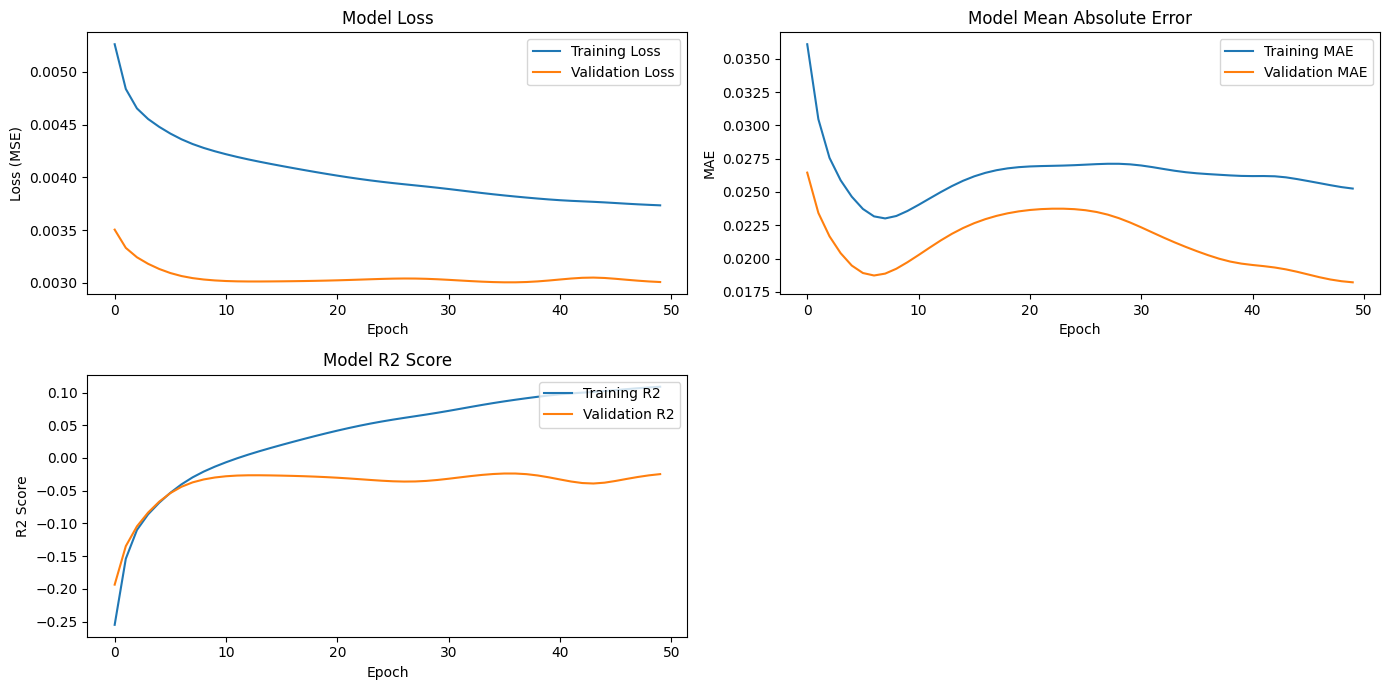

getting error metrics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
# training model with all categories as input

# !! re-running model training for first category and first few houses !!
# !! testing training with 50 seasons (patience: 25)
batch_size=512

input_categories = prediction_categories
test_values_per_house, test_dataset_per_house = get_test_data_per_house(input_categories, batch_size=batch_size, category='blr_mod_lvl', output_category='blr_mod_lvl')
#for num_of_houses in possible_num_of_houses[2]:
num_of_houses = 2
print("---NEW LSTM MODEL---")
print("input_categories: "+str(input_categories))
print("num_of_houses: "+str(num_of_houses))
print("--------------------")
model, history, input_categories, num_of_houses = lstm_model_complete(train_data, val_data, input_categories, num_of_houses, batch_size=batch_size, output_category='blr_mod_lvl')
doing_testing(model, input_categories, num_of_houses, test_values_per_house, test_dataset_per_house, category='blr_mod_lvl', save_path='/content/drive/Othercomputers/My_Laptop/code/lstm_predictions/', path_to_lstm_error_metrics='/content/drive/Othercomputers/My_Laptop/code/lstm_error_metrics.csv')
print("--------------------")

---NEW LSTM MODEL---
input_categories: ['day_of_year', 'hour', 'minute', 'blr_mod_lvl', 'flame', 't_r', 't_r_set', 't_set', 't_ret', 'otc_cur']
num_of_houses: 1
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(134, 1440, 10)
(134, 1440)
(33, 1440, 10)
(33, 1440)
Number of categories for prediction: 10
making transformer model
training transformer model
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0031 - mean_absolute_error: 0.0263 - r2_score: -0.2665 - val_loss: 0.0019 - val_mean_absolute_error: 0.0168 - val_r2_score: -0.1389
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0027 - mean_absolute_error: 0.0205 - r2_score: -0.1338 - val_loss: 0.0018 - val_mean_absolute_error: 0.0141 - val_r2_score: -0.0820
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.0026 - mean_absolute_error: 0.0171 - r2_score: -0.0767 - val_loss: 0.0018 - val_mean_absolute_error: 0.0129 - val_r2_score: -0.0608
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.0026 - mean_absolute_error: 0.0154 - r2_score: -0.0532 - val_loss: 0.0018 - val_mean_absolute_error: 0.0124 - val_r2_score: -0.0520
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.0025 - mean_absolute_error: 0.0147 - r2_score: -0.0431 - val_loss: 0.0017 - val_mean_absolute_error: 0.0121 - val_r2_score: -0.0460
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - lo

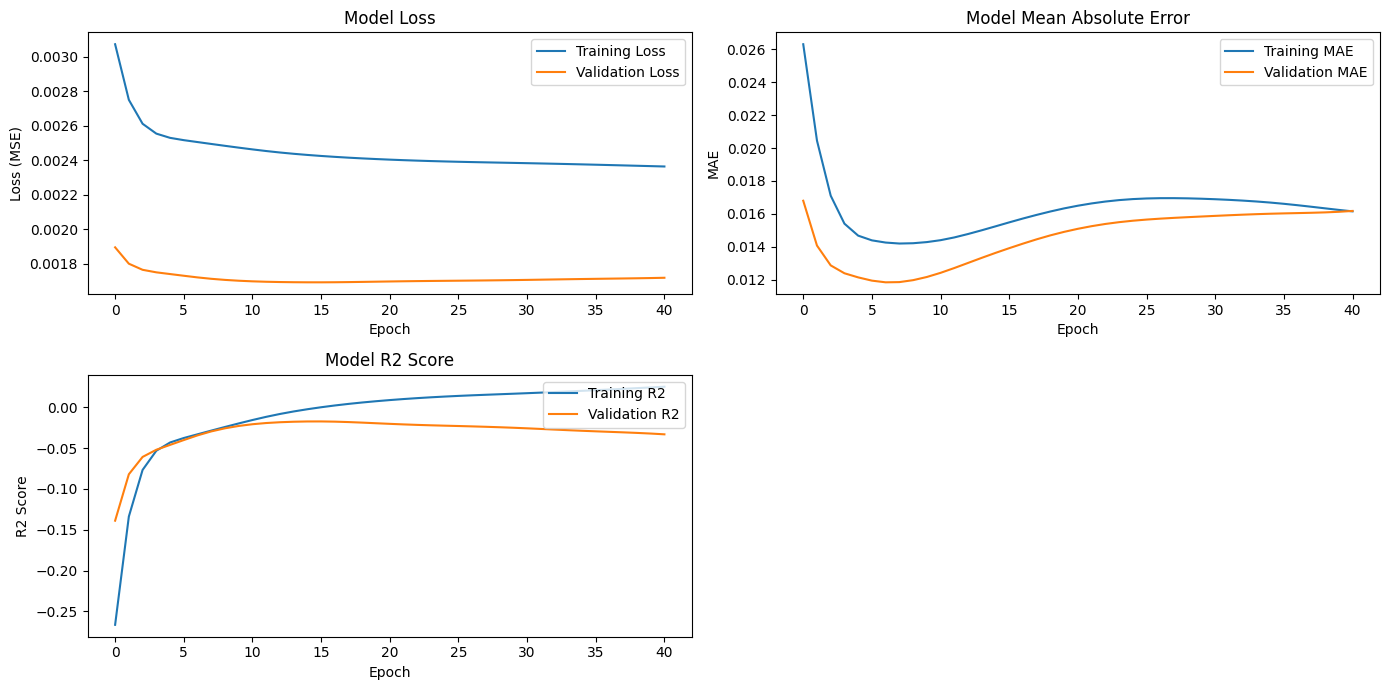

getting error metrics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
# training model with some selected categories as input

# !! re-running model training for first category and first few houses !!
# !! testing training with 50 seasons (patience: 25)
batch_size=512


input_categories = ['day_of_year', 'hour', 'minute', 'blr_mod_lvl', 'flame', 't_r', 't_r_set', 't_set', 't_ret', 'otc_cur']
test_values_per_house, test_dataset_per_house = get_test_data_per_house(input_categories, batch_size=batch_size, category='blr_mod_lvl', output_category='blr_mod_lvl')
for num_of_houses in possible_num_of_houses[:1]:
    print("---NEW LSTM MODEL---")
    print("input_categories: "+str(input_categories))
    print("num_of_houses: "+str(num_of_houses))
    print("--------------------")
    model, history, input_categories, num_of_houses = lstm_model_complete(train_data, val_data, input_categories, num_of_houses, batch_size=batch_size, output_category='blr_mod_lvl')
    doing_testing(model, input_categories, num_of_houses, test_values_per_house, test_dataset_per_house, category='blr_mod_lvl', save_path='/content/drive/Othercomputers/My_Laptop/code/lstm_predictions/', path_to_lstm_error_metrics='/content/drive/Othercomputers/My_Laptop/code/lstm_error_metrics.csv')
    print("--------------------")

In [ ]:
path_to_lstm_error_metrics = '/content/drive/Othercomputers/My_Laptop/code/lstm_error_metrics.csv'
lstm_error_metrics = pd.read_csv(path_to_lstm_error_metrics, index_col=0)
lstm_error_metrics = lstm_error_metrics.sort_values(by=['num_of_houses', 'num_of_categories', 'categories'])
print(lstm_error_metrics.to_string(index=True))

                                                                                                                                                                                                                                                                                                                categories  num_of_categories  num_of_houses  MAE_relevant_houses  MSE_relevant_houses  RMSE_relevant_houses  R2_relevant_houses  MAE_all_houses  MSE_all_houses  RMSE_all_houses  R2_all_houses  MAE_home9  MSE_home9  RMSE_home9  R2_home9  MAE_home114  MSE_home114  RMSE_home114  R2_home114  MAE_home5  MSE_home5  RMSE_home5  R2_home5  MAE_home89  MSE_home89  RMSE_home89  R2_home89  MAE_home17  MSE_home17  RMSE_home17  R2_home17  MAE_home63  MSE_home63  RMSE_home63  R2_home63  MAE_home2  MSE_home2  RMSE_home2  R2_home2  MAE_home101  MSE_home101  RMSE_home101  R2_home101  MAE_home14  MSE_home14  RMSE_home14  R2_home14  MAE_home95  MSE_home95  RMSE_home95  R2_home95  MAE_home111  MSE_home111  

**------------------------------------------------------------------**

---
**-------------------Μερικές Δοκιμές---------------------------**

---
**-------------------------------------------------------------------**

---NEW LSTM MODEL---
input_categories: ['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out', 'blr_t', 'heat', 'flame', 'water', 't_ret', 't_r', 't_set', 'otc_cur', 'otc_maxt', 'bypass', 'year', 'month', 'day', 'day_of_year', 'hour', 'minute']
num_of_houses: 1
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(134, 1440, 21)
(134, 1440)
(33, 1440, 21)
(33, 1440)
Number of categories for prediction: 21
making transformer model
training transformer model
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0843 - mean_absolute_error: 0.2786 - r2_score: -15.0666 - val_loss: 0.0772 - val_mean_absolute_error: 0.2680 - val_r2_score: -17.4002
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step - loss: 0.0807 - mean_absolute_error: 0.2727 - r2_score: -14.3741 - val_loss: 0.0738 - val_mean_absolute_error: 0.2615 - val_r2_score: -16.5866
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.0773 - mean_absolute_error: 0.2661 - r2_score: -13.7281 - val_loss: 0.0697 - val_mean_absolute_error: 0.2528 - val_r2_score: -15.6072
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - loss: 0.0730 - mean_absolute_error: 0.2572 - r2_score: -12.9172 - val_loss: 0.0643 - val_mean_absolute_error: 0.2408 - val_r2_score: -14.3392
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 0.0675 - mean_absolute_error: 0.2445 - r2_score: -11.8526 - val_loss: 0.0576 - val_mean_absolute_error: 0.2242 - val_r2_score: -12.7410
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms

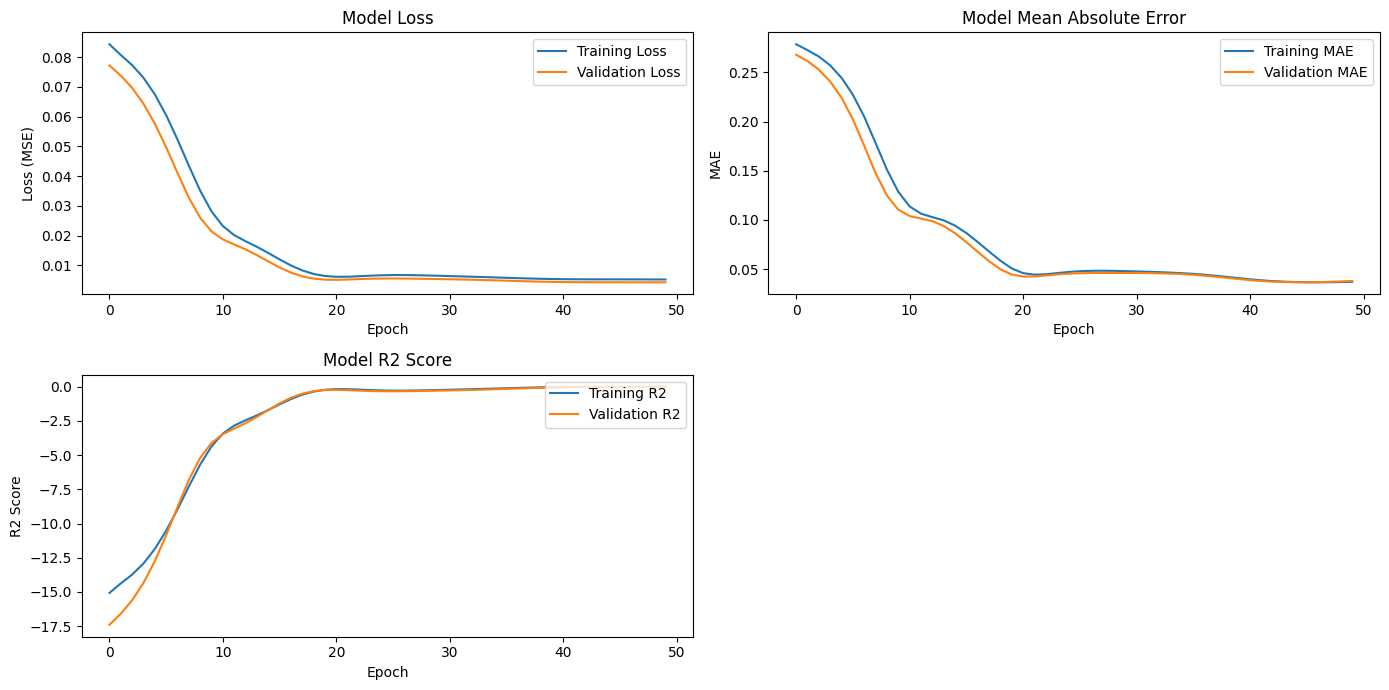

getting error metrics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# !!! training to predict 'absorption' instead of 'blr_mod_lvl' !!!
# !! testing training with 50 seasons (patience = 25)
batch_size=512

#for input_category in prediction_categories:
#input_categories = [input_category]
input_categories = prediction_categories
test_values_per_house, test_dataset_per_house = get_test_data_per_house(input_categories, batch_size=batch_size, category='absorption', output_category='absorption')
for num_of_houses in possible_num_of_houses[:1]:
        print("---NEW LSTM MODEL---")
        print("input_categories: "+str(input_categories))
        print("num_of_houses: "+str(num_of_houses))
        print("--------------------")
        model, history, input_categories, num_of_houses = lstm_model_complete(train_data, val_data, input_categories, num_of_houses, batch_size=batch_size, output_category='absorption')
        doing_testing(model, input_categories, num_of_houses, test_values_per_house, test_dataset_per_house, category='absorption', save_path='/content/drive/Othercomputers/My_Laptop/code/predicting_absorption/lstm_predictions/', path_to_lstm_error_metrics='/content/drive/Othercomputers/My_Laptop/code/predicting_absorption/absorption_lstm_error_metrics.csv')
        print("--------------------")

In [ ]:
# defines one specific model name
input_categories = [prediction_categories[1]]
[num_of_houses] = [possible_num_of_houses[0]]
num_of_categories = len(input_categories)
categories_used = '_'.join(input_categories)
houses_used = str(num_of_houses)
model_name = 'lstm_'+categories_used+"_houses_"+houses_used

print(model_name)

lstm_absorption_houses_1


In [ ]:
# load the saved csvwith predictions
def load_predictions_csv(model_name, predictions_folder_path='/content/drive/Othercomputers/My_Laptop/code/predicting_absorption/lstm_predictions/'):
    folder_name = model_name + '_predictions'
    folder_path = os.path.join(predictions_folder_path, folder_name)
    predictions = {}
    for house in houses:
        file_name = house+'predictions.csv'
        file_path = os.path.join(folder_path, file_name)
        predictions[house] = pd.read_csv(file_path)
    return predictions

In [ ]:
# this will hold the Target, Prediction values per house for the models
lstm_model_predictions = {}

# used to load one predetermined model
#lstm_model_predictions[model_name] = load_predictions_csv(model_name) # used for models predicting 'blr_mod_lvl'

# used for models predicting 'absorption'
lstm_model_predictions[model_name] = load_predictions_csv(model_name, predictions_folder_path='/content/drive/Othercomputers/My_Laptop/code/predicting_absorption/lstm_predictions/')

In [ ]:
def plot_lstm_predictions(lstm_model_predictions, model_name, houses):
    # Get predictions for the selected model
    predictions = lstm_model_predictions[model_name]

    num_of_houses = len(houses)

    # Create a figure with subplots (one for each house)
    fig, axs = plt.subplots(num_of_houses, 1, figsize=(10, 5 * num_of_houses), sharex=True)

    # If only one house, wrap axs in a list
    if num_of_houses == 1:
        axs = [axs]

    for idx, house in enumerate(houses):
        house_predictions = predictions[house]

        # only keep the first day (first 1440 values) from data for plotting
        target_values = house_predictions['Target'][:1440]
        prediction_values = house_predictions['Prediction'][:1440]
        error_values = target_values - prediction_values

        axs[idx].plot(target_values, linestyle='-', label='Target Values')  # Plot the values
        axs[idx].plot(prediction_values, linestyle='-', label='Prediction Values')  # Plot the values

        # Set subplot title and labels
        axs[idx].set_title('Model: '+model_name+' Predictions for House: '+house)
        axs[idx].set_ylabel('Values')
        axs[idx].legend()

    # Set common x-axis label
    axs[-1].set_xlabel('Time (minutes of the day)')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the plot
    plt.show()

In [ ]:
plot_lstm_predictions(lstm_model_predictions, model_name, houses)

Output hidden; open in https://colab.research.google.com to view.



---


---

**Predicting t_out**

---



---




---NEW LSTM MODEL---
input_categories: ['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out', 'blr_t', 'heat', 'flame', 'water', 't_ret', 't_r', 't_set', 'otc_cur', 'otc_maxt', 'bypass', 'year', 'month', 'day', 'day_of_year', 'hour', 'minute']
num_of_houses: 1
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(134, 1440, 21)
(134, 1440)
(33, 1440, 21)
(33, 1440)
Number of categories for prediction: 21
making transformer model
training transformer model
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2470 - mean_absolute_error: 0.4637 - r2_score: -6.9377 - val_loss: 0.1894 - val_mean_absolute_error: 0.4199 - val_r2_score: -14.1817
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.2413 - mean_absolute_error: 0.4577 - r2_score: -6.7554 - val_loss: 0.1848 - val_mean_absolute_error: 0.4140 - val_r2_score: -13.8162
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.2355 - mean_absolute_error: 0.4510 - r2_score: -6.5678 - val_loss: 0.1787 - val_mean_absolute_error: 0.4059 - val_r2_score: -13.3223
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.2279 - mean_absolute_error: 0.4420 - r2_score: -6.3240 - val_loss: 0.1701 - val_mean_absolute_error: 0.3943 - val_r2_score: -12.6372
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.2176 - mean_absolute_error: 0.4294 - r2_score: -5.9917 - val_loss: 0.1585 - val_mean_absolute_error: 0.3779 - val_r2_score: -11.7093
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step

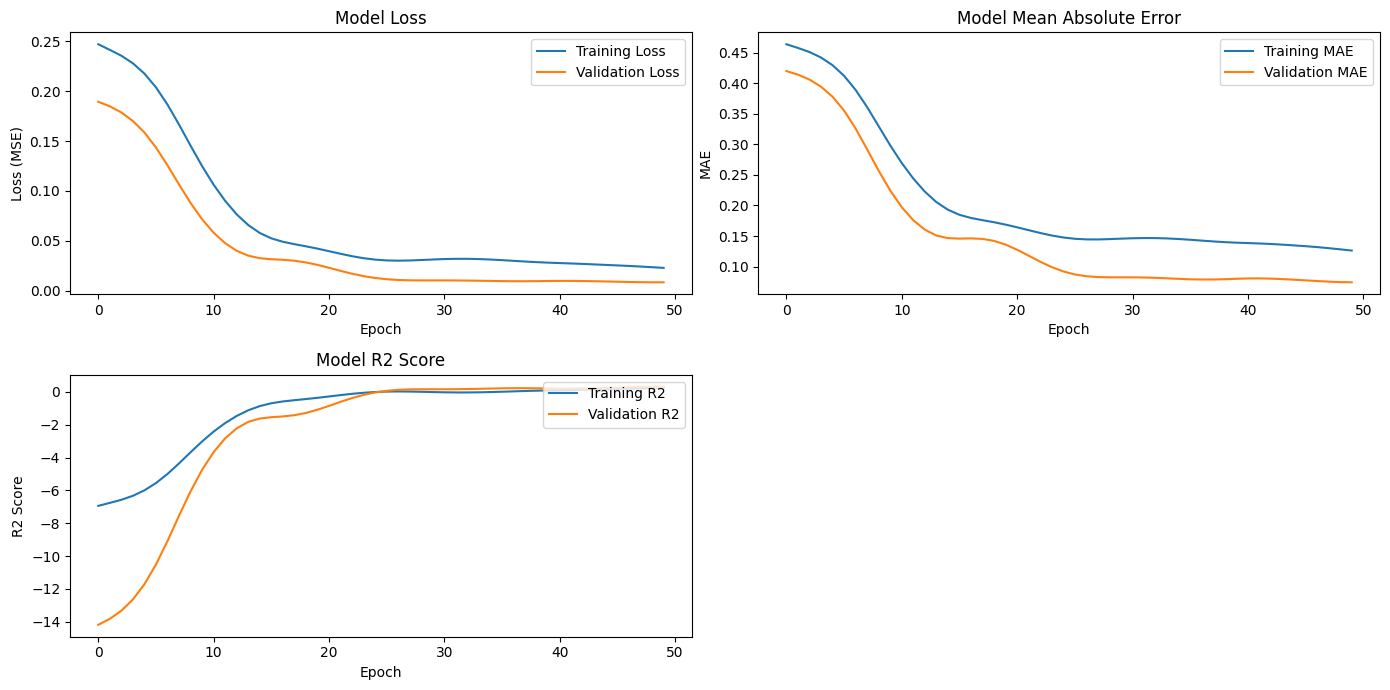

getting error metrics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
# !!! training to predict 't_out' instead of 'blr_mod_lvl' !!!
# !! testing training with 50 seasons (patience = 25)
batch_size=512

#for input_category in prediction_categories:
#    input_categories = [input_category]
input_categories = prediction_categories
test_values_per_house, test_dataset_per_house = get_test_data_per_house(input_categories, batch_size=batch_size, category='t_out', output_category='t_out')
for num_of_houses in possible_num_of_houses[:1]:
        print("---NEW LSTM MODEL---")
        print("input_categories: "+str(input_categories))
        print("num_of_houses: "+str(num_of_houses))
        print("--------------------")
        model, history, input_categories, num_of_houses = lstm_model_complete(train_data, val_data, input_categories, num_of_houses, batch_size=batch_size, output_category='t_out')
        doing_testing(model, input_categories, num_of_houses, test_values_per_house, test_dataset_per_house, category='t_out', save_path='/content/drive/Othercomputers/My_Laptop/code/predicting_t_out/lstm_predictions/', path_to_lstm_error_metrics='/content/drive/Othercomputers/My_Laptop/code/predicting_t_out/t_out_lstm_error_metrics.csv')
        print("--------------------")

In [ ]:
# defines one specific model name
input_categories = [prediction_categories[4]]
[num_of_houses] = [possible_num_of_houses[0]]
num_of_categories = len(input_categories)
categories_used = '_'.join(input_categories)
houses_used = str(num_of_houses)
model_name = 'lstm_'+categories_used+"_houses_"+houses_used

print(model_name)

# load the saved csvwith predictions
def load_t_out_predictions_csv(model_name, predictions_folder_path='/content/drive/Othercomputers/My_Laptop/code/predicting_t_out/lstm_predictions/'):
    folder_name = model_name + '_predictions'
    folder_path = os.path.join(predictions_folder_path, folder_name)
    predictions = {}
    for house in houses:
        file_name = house+'predictions.csv'
        file_path = os.path.join(folder_path, file_name)
        predictions[house] = pd.read_csv(file_path)
    return predictions

lstm_t_out_houses_1


In [ ]:
# this will hold the Target, Prediction values per house for the models
lstm_model_t_out_predictions = {}

# used for models predicting 't_out'
lstm_model_t_out_predictions[model_name] = load_t_out_predictions_csv(model_name)

In [ ]:
plot_lstm_predictions(lstm_model_t_out_predictions, model_name, houses) # using the plotting function from above

Output hidden; open in https://colab.research.google.com to view.



---



---

**Predicting insulation = t_r - t_out**


---



---



---NEW LSTM MODEL---
input_categories: ['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out', 'blr_t', 'heat', 'flame', 'water', 't_ret', 't_r', 't_set', 'otc_cur', 'otc_maxt', 'bypass', 'year', 'month', 'day', 'day_of_year', 'hour', 'minute']
num_of_houses: 1
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(134, 1440, 21)
(134, 1440)
(33, 1440, 21)
(33, 1440)
Number of categories for prediction: 21
making transformer model
training transformer model
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2898 - mean_absolute_error: 0.5127 - r2_score: -10.2438 - val_loss: 0.2503 - val_mean_absolute_error: 0.4858 - val_r2_score: -17.8198
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.2827 - mean_absolute_error: 0.5060 - r2_score: -9.9710 - val_loss: 0.2431 - val_mean_absolute_error: 0.4780 - val_r2_score: -17.2815
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.2752 - mean_absolute_error: 0.4982 - r2_score: -9.6777 - val_loss: 0.2337 - val_mean_absolute_error: 0.4674 - val_r2_score: -16.5734
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.2653 - mean_absolute_error: 0.4877 - r2_score: -9.2950 - val_loss: 0.2212 - val_mean_absolute_error: 0.4527 - val_r2_score: -15.6321
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.2522 - mean_absolute_error: 0.4732 - r2_score: -8.7875 - val_loss: 0.2051 - val_mean_absolute_error: 0.4329 - val_r2_score: -14.4188
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/ste

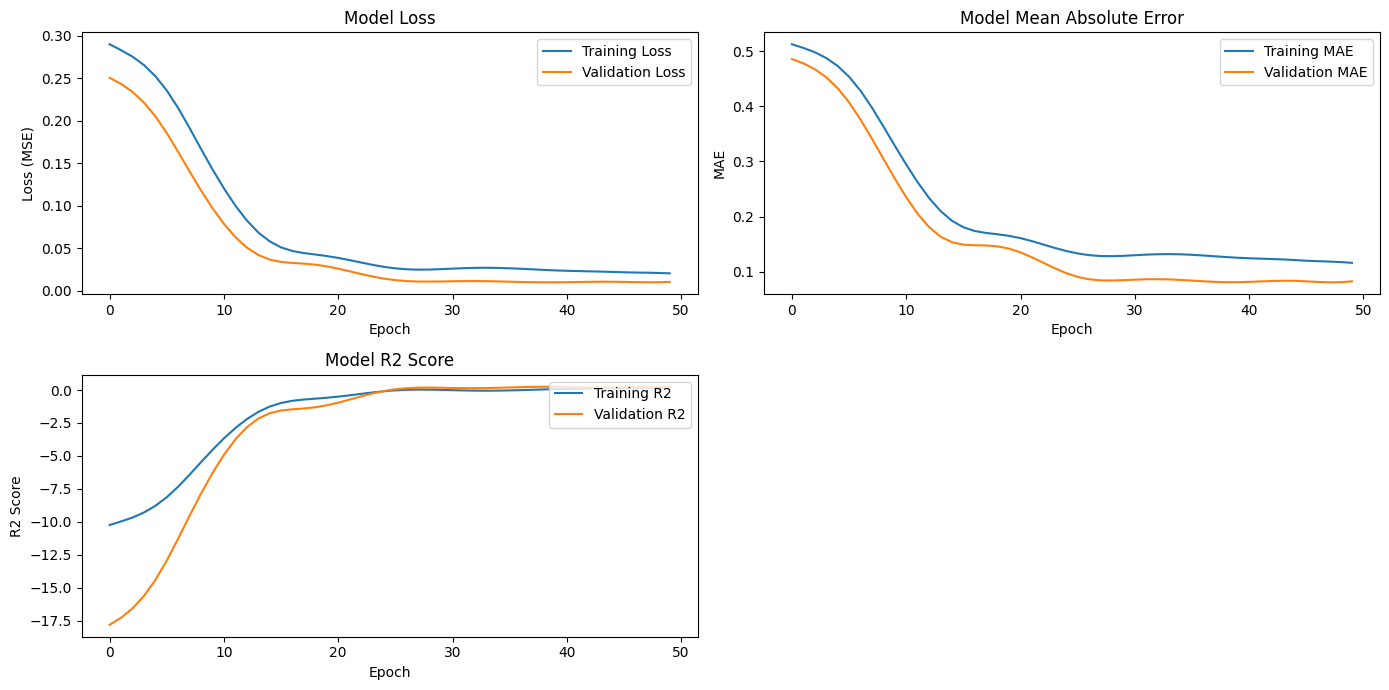

getting error metrics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
# !!! training to predict 'insulation' instead of 'blr_mod_lvl' !!!
# testing training with 50 seasons (patience = 25)
batch_size=512

#for input_category in prediction_categories:
#    input_categories = [input_category]
input_categories = prediction_categories
test_values_per_house, test_dataset_per_house = get_test_data_per_house(input_categories, batch_size=batch_size, category='insulation', output_category='insulation')
for num_of_houses in possible_num_of_houses[:1]:
        print("---NEW LSTM MODEL---")
        print("input_categories: "+str(input_categories))
        print("num_of_houses: "+str(num_of_houses))
        print("--------------------")
        model, history, input_categories, num_of_houses = lstm_model_complete(train_data, val_data, input_categories, num_of_houses, batch_size=batch_size, output_category='insulation')
        doing_testing(model, input_categories, num_of_houses, test_values_per_house, test_dataset_per_house, category='insulation', save_path='/content/drive/Othercomputers/My_Laptop/code/predicting_insulation/lstm_predictions/', path_to_lstm_error_metrics='/content/drive/Othercomputers/My_Laptop/code/predicting_insulation/insulation_lstm_error_metrics.csv')
        print("--------------------")

In [ ]:
# defines one specific model name
input_categories = [prediction_categories[2]]
[num_of_houses] = [possible_num_of_houses[0]]
num_of_categories = len(input_categories)
categories_used = '_'.join(input_categories)
houses_used = str(num_of_houses)
model_name = 'lstm_'+categories_used+"_houses_"+houses_used

print(model_name)

# load the saved csvwith predictions
def load_insulation_predictions_csv(model_name, predictions_folder_path='/content/drive/Othercomputers/My_Laptop/code/predicting_insulation/lstm_predictions/'):
    folder_name = model_name + '_predictions'
    folder_path = os.path.join(predictions_folder_path, folder_name)
    predictions = {}
    for house in houses:
        file_name = house+'predictions.csv'
        file_path = os.path.join(folder_path, file_name)
        predictions[house] = pd.read_csv(file_path)
    return predictions

lstm_insulation_houses_1


In [ ]:
# this will hold the Target, Prediction values per house for the models
lstm_model_insulation_predictions = {}

# used for models predicting 'insulation'
lstm_model_insulation_predictions[model_name] = load_insulation_predictions_csv(model_name)

In [ ]:
plot_lstm_predictions(lstm_model_insulation_predictions, model_name, houses) # using the plotting function from above

Output hidden; open in https://colab.research.google.com to view.



---



---



---



---






---


---



---

**Testing other version for LSTM**

---



---



---



In [32]:
print(prediction_categories)
print(prediction_categories[:1])
print(possible_num_of_houses)
print(possible_num_of_houses[3:])

['blr_mod_lvl', 'absorption', 'insulation', 't_r_set', 't_out', 'blr_t', 'heat', 'flame', 'water', 't_ret', 't_r', 't_set', 'otc_cur', 'otc_maxt', 'bypass', 'year', 'month', 'day', 'day_of_year', 'hour', 'minute']
['blr_mod_lvl']
[1, 4, 14, 28]
[28]


---NEW LSTM MODEL---
input_categories: ['blr_mod_lvl', 'year', 'day_of_year', 'hour', 'minute']
num_of_houses: 1
--------------------
splitting data
getting datasets
printing shapes and getting num_of_categories
(134, 1440, 5)
(134, 1440)
(33, 1440, 5)
(33, 1440)
Number of categories for prediction: 5
making transformer model


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


training transformer model
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0036 - mean_absolute_error: 0.0407 - r2_score: -0.5251 - val_loss: 0.0017 - val_mean_absolute_error: 0.0063 - val_r2_score: -0.0239
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 745ms/step - loss: 0.0025 - mean_absolute_error: 0.0118 - r2_score: -0.1267 - val_loss: 0.0017 - val_mean_absolute_error: 0.0063 - val_r2_score: -0.0239
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 742ms/step - loss: 0.0025 - mean_absolute_error: 0.0100 - r2_score: -0.0953 - val_loss: 0.0017 - val_mean_absolute_error: 0.0063 - val_r2_score: -0.0239
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step - loss: 0.0024 - mean_absolute_error: 0.0085 - r2_score: -0.0630 - val_loss: 0.0017 - val_mean_absolute_error: 0.0063 - val_r2_score: -0.0239
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 729ms/step - loss: 0.0024 - mean_absolute_error: 0.0083 - r2_score: -0.0627 - val_loss: 0.0017 - val_mean_absolute_error: 0.0063 - val_r2_score: -0.0239
Epoch 6/100

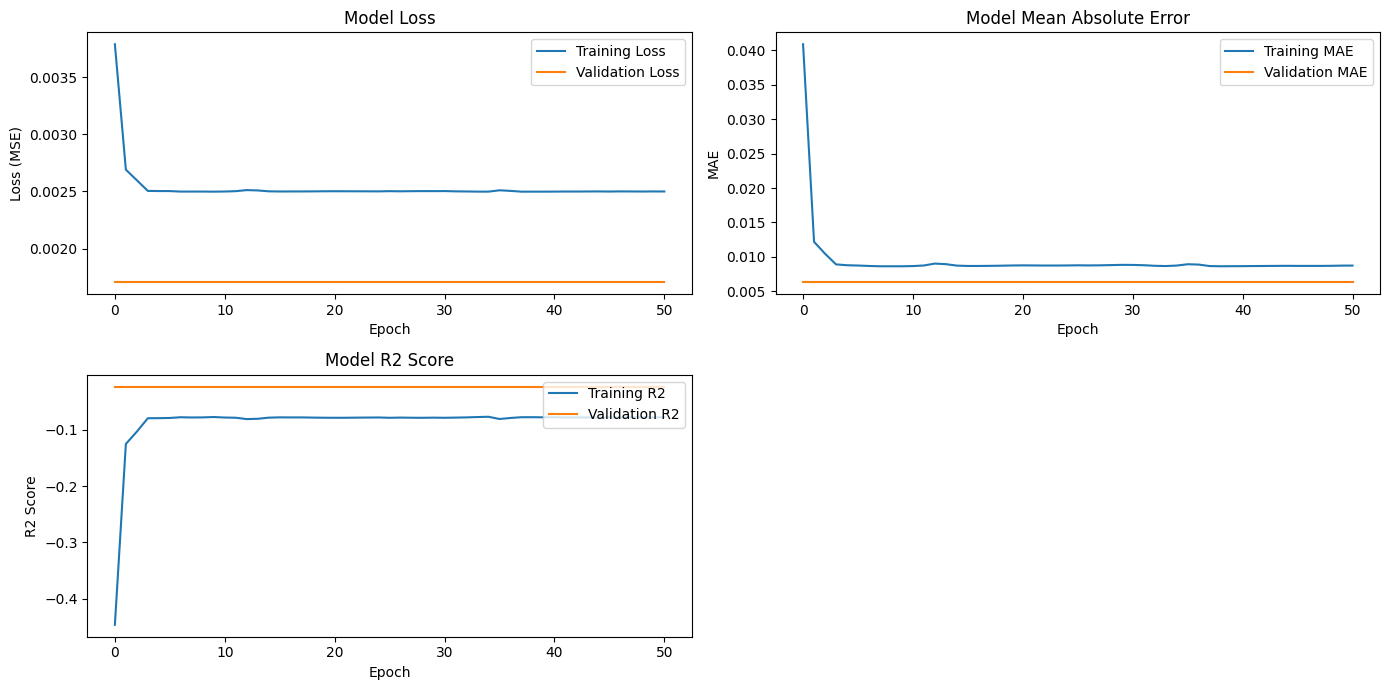

getting error metrics
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1

In [33]:
# !! Other version of LSTM

# !! training the new version of lstm model
# !! training with 100 seasons (patience: 25)
batch_size=128
#batch_size=512

input_categories = ['blr_mod_lvl', 'year', 'day_of_year', 'hour', 'minute']
#for input_category in prediction_categories[:1]:
#    input_categories = [input_category]
test_values_per_house, test_dataset_per_house = get_test_data_per_house(input_categories, batch_size=batch_size, category='blr_mod_lvl', output_category='blr_mod_lvl')
for num_of_houses in possible_num_of_houses[:1]:
        print("---NEW LSTM MODEL---")
        print("input_categories: "+str(input_categories))
        print("num_of_houses: "+str(num_of_houses))
        print("--------------------")
        model, history, input_categories, num_of_houses = lstm_model_complete(train_data, val_data, input_categories, num_of_houses, batch_size=batch_size, output_category='blr_mod_lvl')
        doing_testing(model, input_categories, num_of_houses, test_values_per_house, test_dataset_per_house, category='blr_mod_lvl', save_path='/content/drive/Othercomputers/My_Laptop/code/alternate_lstm/lstm_predictions/', path_to_lstm_error_metrics='/content/drive/Othercomputers/My_Laptop/code/alternate_lstm/lstm_error_metrics.csv')
        print("--------------------")